In [1]:
import pandas as pd
import numpy as np
import datetime   # datetime 내 timedelta는 몇주전후 까지만 나와 있음
from dateutil.relativedelta import relativedelta # 몇달전후, 몇년전후를 구하기 위함
from tqdm import tqdm
from scipy import stats

In [2]:
data=pd.read_csv('HPAI_Weather_occur.csv', encoding='utf-8-sig')

In [3]:
data.head()

,주소,축종,사육수,진단일,발생일,지역코드,지역명,시도,시군구,location,date,avg_temp(C),lowest_temp(C),highest_temp(C),daily_rain(mm),maxWsWd(16방위),avg_wind(m/s),avg_r_humidity(%)
0,강원도 원주시 귀래면 주포리,닭-산란계,170000,20210224,20210223,114,원주,강원도,원주시,원주,20210223,1.9,-1.2,6.4,0.0,270.0,1.4,28.0
1,강원도 인제군 기린면 북리,닭-산란계,28500,20170107,20170103,211,인제,강원도,인제군,인제,20170103,1.2,-4.0,6.2,0.0,160.0,2.2,60.1
2,강원도 철원군 갈말읍 강포리,닭-산란계,16000,20161212,20161209,95,철원,강원도,철원군,철원,20161209,-0.1,-6.3,3.7,1.7,270.0,1.6,68.9
3,강원도 철원군 갈말읍 강포리,닭-산란계,30000,20161203,20161130,95,철원,강원도,철원군,철원,20161130,3.2,-4.7,8.9,1.2,230.0,0.9,72.1
4,강원도 춘천시 사북면 지촌리,닭-산란계,48,20080507,20080507,101,춘천,강원도,춘천시,춘천,20080507,13.2,7.3,20.9,17.0,180.0,0.6,66.1


In [4]:
# 필요없는 열 삭제
# 평균온도, 일강수량, 평균풍속, 평균상대습도 data만 확보
data_df=data.drop(['축종', '주소', '진단일', '사육수', '지역명', 'location', 'date', 'lowest_temp(C)',
                  'highest_temp(C)', 'maxWsWd(16방위)'], axis=1) 

In [5]:
data_df['발생일']=data_df['발생일'].astype('str')

In [6]:
data_df.head()

,발생일,지역코드,시도,시군구,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,20210223,114,강원도,원주시,1.9,0.0,1.4,28.0
1,20170103,211,강원도,인제군,1.2,0.0,2.2,60.1
2,20161209,95,강원도,철원군,-0.1,1.7,1.6,68.9
3,20161130,95,강원도,철원군,3.2,1.2,0.9,72.1
4,20080507,101,강원도,춘천시,13.2,17.0,0.6,66.1


In [7]:
# 문자열을 datetime 형식으로 바꾸기
data_df['발생일']=data_df['발생일'].map(lambda x : datetime.datetime.strptime(x, '%Y%m%d'))

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1122 entries, 0 to 1121
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   발생일                1122 non-null   datetime64[ns]
 1   지역코드               1122 non-null   int64         
 2   시도                 1122 non-null   object        
 3   시군구                1122 non-null   object        
 4   avg_temp(C)        1122 non-null   float64       
 5   daily_rain(mm)     1122 non-null   float64       
 6   avg_wind(m/s)      1122 non-null   float64       
 7   avg_r_humidity(%)  1122 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 70.2+ KB


In [9]:
# 월별 데이터 만들기
data_df['month']=data_df['발생일'].map(lambda x: x.month)
data_df['year']=data_df['발생일'].map(lambda x: x.year)

In [10]:
data_df.head()

,발생일,지역코드,시도,시군구,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),month,year
0,2021-02-23,114,강원도,원주시,1.9,0.0,1.4,28.0,2,2021
1,2017-01-03,211,강원도,인제군,1.2,0.0,2.2,60.1,1,2017
2,2016-12-09,95,강원도,철원군,-0.1,1.7,1.6,68.9,12,2016
3,2016-11-30,95,강원도,철원군,3.2,1.2,0.9,72.1,11,2016
4,2008-05-07,101,강원도,춘천시,13.2,17.0,0.6,66.1,5,2008


#### 월별로 된 시도 데이터 중 발생했던 년도와 발생하지 않았던 년도를 비교하기 
    1. 기간은 2003~2020년까지
    2. 비교를 위해서는 발생건수로 확인한다. (가중치가 cnt 비율로 시군별로 들어갈 수 있을 듯)

In [11]:
import weatherAPI 

In [12]:
data_df['cnt']=1

In [13]:
# 발생한 날 시군구 월별 기후 평균 구하기
sido_df=data_df.groupby(['year','month','시도','시군구']).mean()
sido_df['cnt']=data_df.groupby(['year','month','시도','시군구']).sum()['cnt']

In [14]:
sido_df.reset_index(inplace=True)

In [16]:
sido_df.head()

,year,month,시도,시군구,지역코드,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),cnt
0,2003,12,경기도,이천시,203,0.00,0.0,1.600000,66.100,2
1,2003,12,경상북도,경주시,138,6.65,0.0,2.625000,44.775,4
2,2003,12,울산광역시,울주군,152,0.30,0.0,3.200000,29.400,2
3,2003,12,전라남도,나주시,156,0.75,0.0,1.400000,70.200,2
4,2003,12,충청남도,천안시,232,0.00,0.0,1.633333,76.000,3


In [17]:
cols_name=['avg_temp(C)','daily_rain(mm)','avg_wind(m/s)','avg_r_humidity(%)']
other_sido_df=pd.DataFrame(columns=['year','month','시도','시군구','지역코드']+cols_name)

In [18]:
for year in range(2003,2021):
    if year not in set(sido_df['year']):
        for n, group in sido_df.groupby(['month','시도','시군구','지역코드']):
            group.reset_index(inplace=True, drop=True)
            if len(str(n[0]))==1:
                temp_month='0'+str(n[0])
            else:
                temp_month=str(n[0])
            start_date=str(year)+temp_month+'01'
            temp_date=datetime.datetime.strptime(start_date, '%Y%m%d')
            end_date=temp_date+relativedelta(months=1)-datetime.timedelta(days=1)
            end_date=end_date.strftime('%Y%m%d')
            try:
                temp_df=weatherAPI.load2(start_date, end_date, group.loc[0,'지역코드'])
                temp_df.drop(['location', 'date', 'lowest_temp(C)', 'highest_temp(C)', 'maxWsWd(16방위)'], axis=1, inplace=True)
                other_sido_df=other_sido_df.append(np.round(temp_df.mean(),1), ignore_index=True)
                other_sido_df.iloc[-1,0]=year
                other_sido_df.iloc[-1,1]=n[0]
                other_sido_df.iloc[-1,2]=str(n[1])
                other_sido_df.iloc[-1,3]=str(n[2])
                other_sido_df.iloc[-1,4]=n[3]
            except:
                print(f'error, start_date={start_date}, end_date={end_date}, code={group.loc[0,"지역코드"]}')

API error
error, start_date=20050101, end_date=20050131, code=239
API error
error, start_date=20050101, end_date=20050131, code=259
API error
error, start_date=20050101, end_date=20050131, code=174
API error
error, start_date=20050101, end_date=20050131, code=160
API error
error, start_date=20050101, end_date=20050131, code=258
API error
error, start_date=20050101, end_date=20050131, code=252
API error
error, start_date=20050101, end_date=20050131, code=258
API error
error, start_date=20050101, end_date=20050131, code=251
API error
error, start_date=20050101, end_date=20050131, code=177
API error
error, start_date=20050201, end_date=20050228, code=257
API error
error, start_date=20050201, end_date=20050228, code=259
API error
error, start_date=20050201, end_date=20050228, code=174
API error
error, start_date=20050201, end_date=20050228, code=174
API error
error, start_date=20050201, end_date=20050228, code=252
API error
error, start_date=20050201, end_date=20050228, code=252
API error


In [23]:
# 안뽑히는게 있음
weatherAPI.load2('20190101', '20190131', '160')

API error


In [25]:
other_sido_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   year               1374 non-null   float64
 1   month              1374 non-null   float64
 2   시도                 1374 non-null   object 
 3   시군구                1374 non-null   object 
 4   지역코드               1374 non-null   float64
 5   avg_temp(C)        1374 non-null   float64
 6   daily_rain(mm)     1374 non-null   float64
 7   avg_wind(m/s)      1374 non-null   float64
 8   avg_r_humidity(%)  1374 non-null   float64
dtypes: float64(7), object(2)
memory usage: 96.7+ KB


In [24]:
other_sido_df.head()

,year,month,시도,시군구,지역코드,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,2005.0,1.0,강원도,인제군,211.0,-5.4,0.3,1.8,60.9
1,2005.0,1.0,강원도,횡성군,114.0,-3.3,0.1,1.3,55.8
2,2005.0,1.0,경기도,광주시,203.0,-3.1,0.1,1.2,62.1
3,2005.0,1.0,경기도,김포시,112.0,-1.1,0.1,3.1,54.1
4,2005.0,1.0,경기도,남양주시,108.0,-2.5,0.1,2.4,52.2


In [29]:
# 시도 평균을 내서 월별 발생월 비교하기
other=np.round(other_sido_df.groupby(['month','시도']).mean(),1)

In [31]:
# 의미없는 열 제거
other.drop(['year','지역코드'], axis=1, inplace=True)

In [33]:
other.reset_index(inplace=True)

In [35]:
other['month']=other['month'].astype('int')

In [46]:
other.head()

,month,시도,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,1,강원도,-4.4,0.2,1.4,60.0
1,1,경기도,-3.3,0.3,1.6,58.9
2,1,경상남도,0.1,0.4,1.6,54.5
3,1,경상북도,-0.3,0.6,2.3,50.7
4,1,부산광역시,3.1,0.5,3.3,41.8


In [45]:
other.to_csv("month_other_weather.csv", encoding='utf-8-sig', index=False)

In [212]:
other=pd.read_csv("month_other_weather.csv", encoding='utf-8-sig')

In [215]:
# 발생월
occur=np.round(sido_df.groupby(['month','시도']).mean(),1)
occur['cnt']=sido_df.groupby(['month','시도'])['cnt'].sum()

In [216]:
# 의미없는 열 제거
occur.drop(['year','지역코드'], axis=1, inplace=True)

In [217]:
occur.reset_index(inplace=True)

In [218]:
# 5행은 other 데이터에는 없으므로 맞추기 위해서 지움
occur.drop([5], axis=0, inplace=True)

In [219]:
occur.reset_index(inplace=True, drop=True)

In [69]:
occur.to_csv("month_occur_weather.csv", encoding='utf-8-sig', index=False)

In [220]:
occur=pd.read_csv("month_occur_weather.csv", encoding='utf-8-sig')

In [49]:
# 그래프 시각화 하기
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_list = font_manager.findSystemFonts(fontpaths= None, fontext = 'ttf')
path='C:\\Windows\\Fonts\\gulim.ttc'
fontname = font_manager.FontProperties(fname=path).get_name()
plt.rc('font', family=fontname)

In [314]:
np.floor((min(other.query('month==@month').reset_index(drop=True)['avg_temp(C)'])))

-5.0

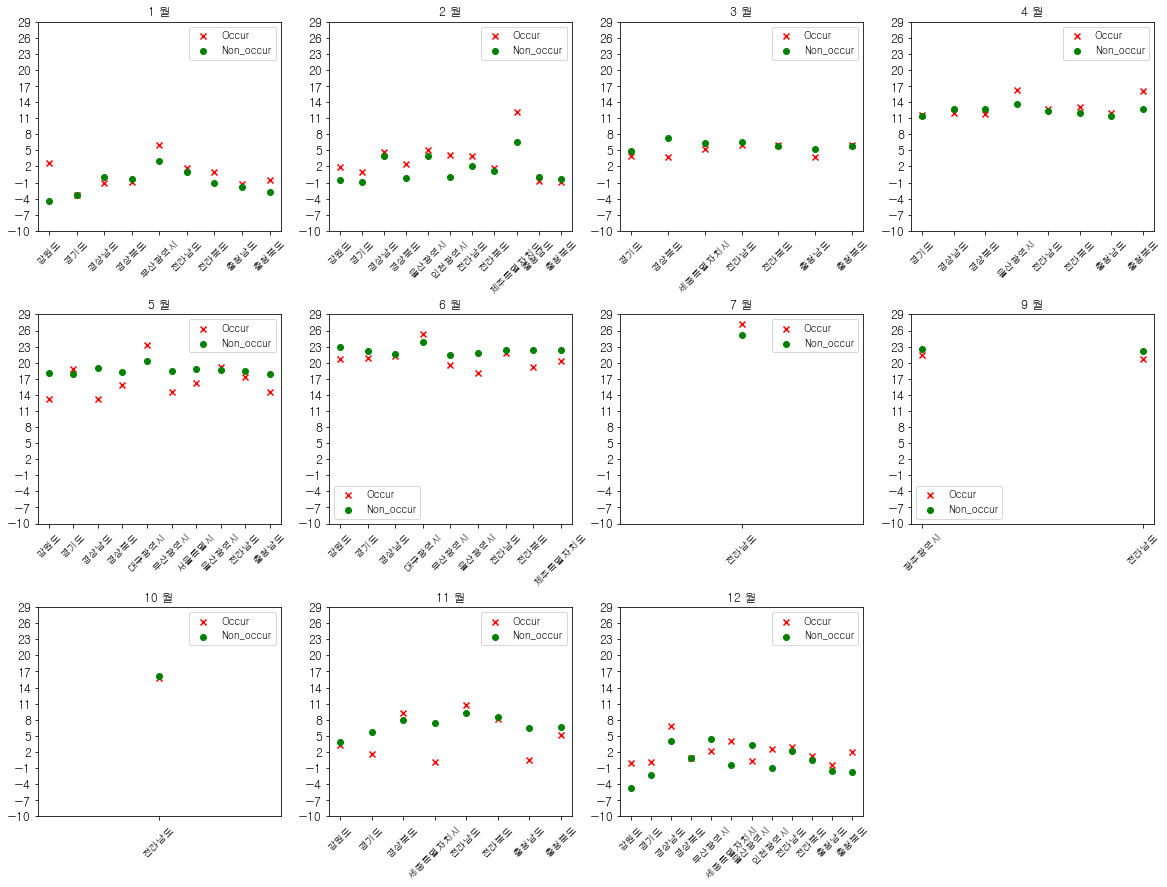

In [337]:
# 온도차이 그래프
plt.figure(figsize=(20,20))
cnt=len(set(occur['month']))
k=1
for month in set(occur['month']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('month==@month').reset_index(drop=True)
    temp2=other.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['avg_temp(C)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['avg_temp(C)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(rotation=45)
    plt.legend()

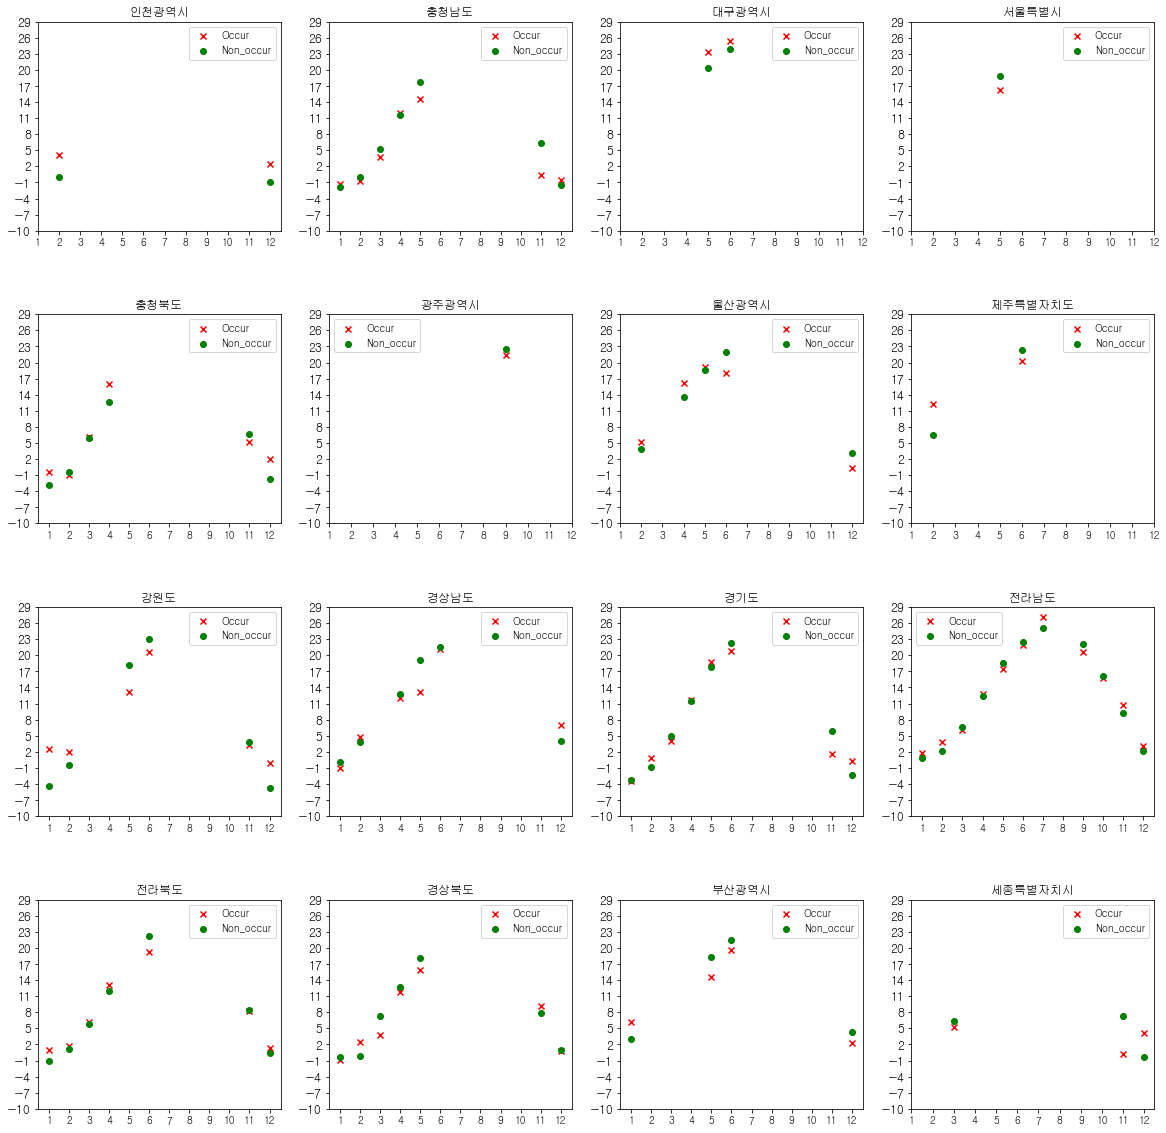

In [336]:
# 온도차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(occur['시도']))
k=1
for sido in set(occur['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('시도==@sido').reset_index(drop=True)
    temp2=other.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['avg_temp(C)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['avg_temp(C)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(range(1,13))
    plt.legend()

- 온도
    - 시도별 뚜렷한 특이성을 찾기 어려움
    - 계절성으로 봐야할듯 ( 겨울은 워낙 온도가 낮아 바이러스와 관계가 없음 )
    - 여름 5-9월 까지는 상대적으로 낮은 온도에서 발생하는 경향이 있음. (7~9월은 data 부족으로 판단)
    - 반면에 겨울에는 겨울 평상시 온도보다 약간 더 높은 온도에서 발생하는 경향이 있음 (12~2월) 

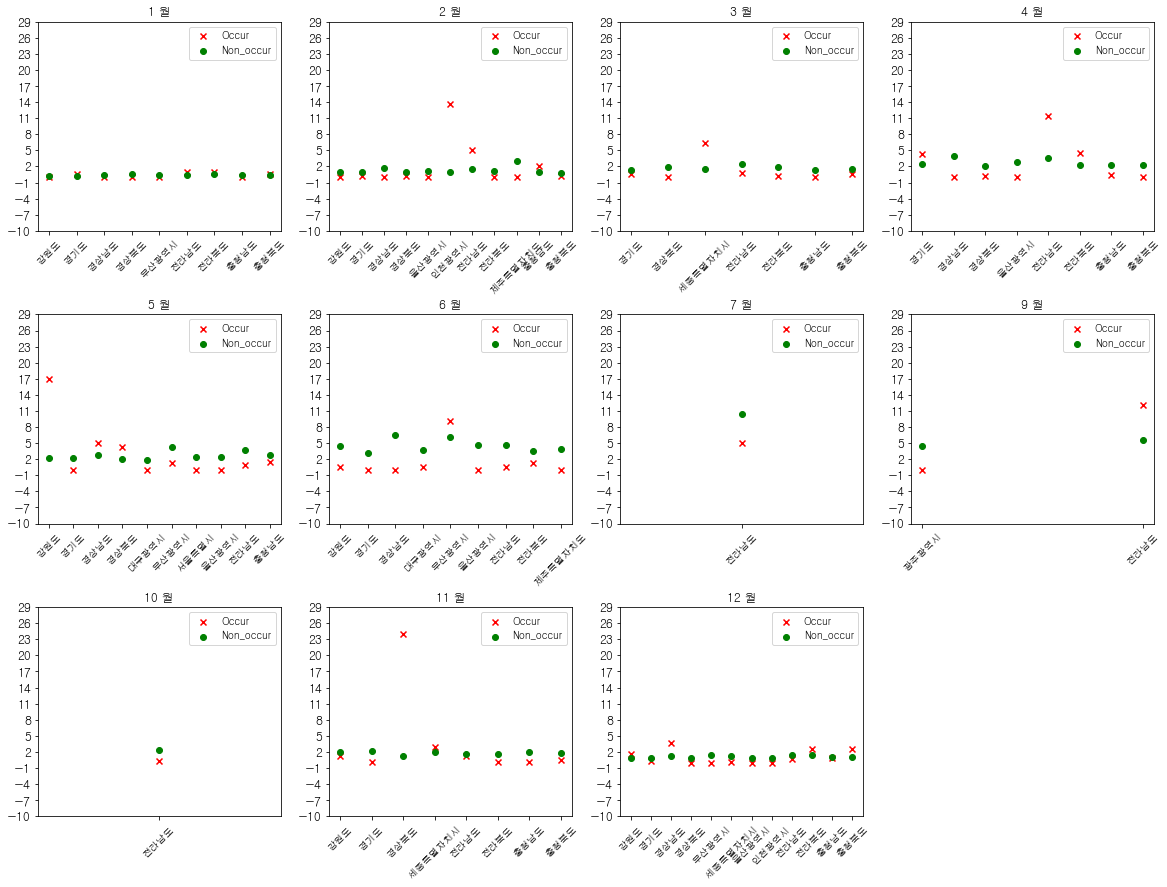

In [335]:
# 일 강수량 차이 그래프
plt.figure(figsize=(20,20))
cnt=len(set(occur['month']))
k=1
for month in set(occur['month']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('month==@month').reset_index(drop=True)
    temp2=other.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['daily_rain(mm)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['daily_rain(mm)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(rotation=45)
    plt.legend()

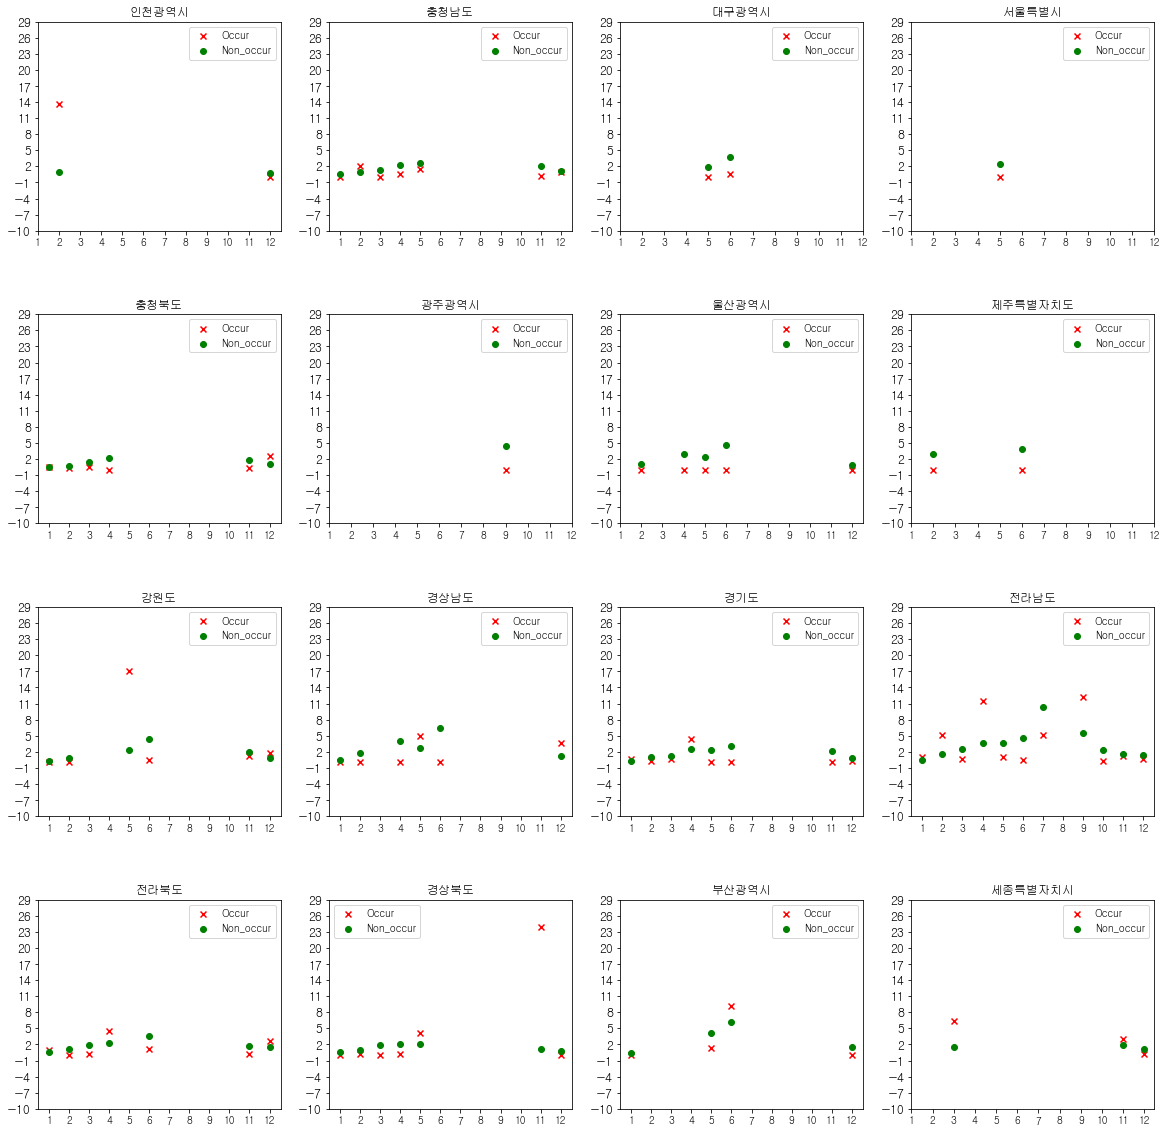

In [334]:
# 강수량차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(occur['시도']))
k=1
for sido in set(occur['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('시도==@sido').reset_index(drop=True)
    temp2=other.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['daily_rain(mm)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['daily_rain(mm)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(range(1,13))
    plt.legend()

- 일 강수량
    - 시도별 특징은 찾기 어려움
    - 온도와 마찬가지로 계절적인 영향이 있는 듯 보임
    - 여름 5-9월 까지는 상대적으로 낮은 강수량일 경우 발생하는 경향이 있음. (7~9월은 data 부족으로 판단)

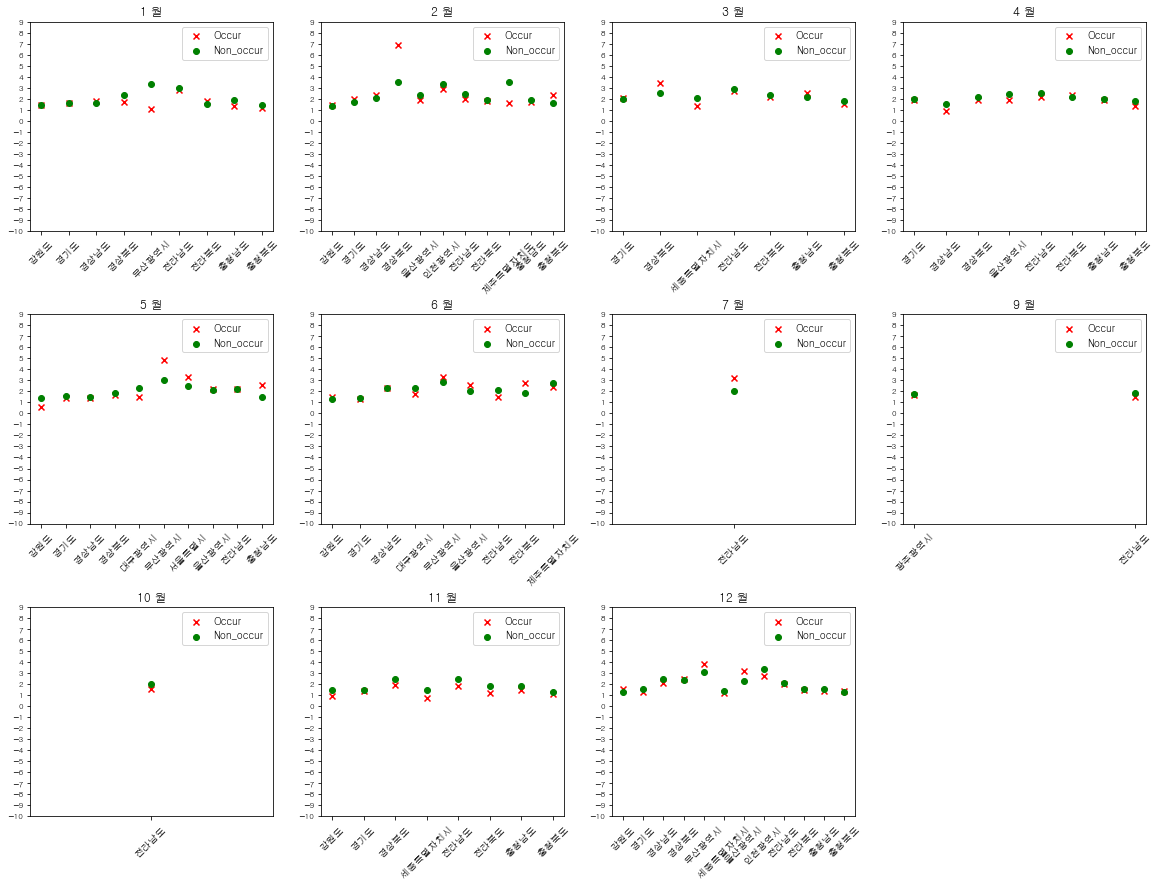

In [328]:
# 풍속차이 그래프
plt.figure(figsize=(20,20))
cnt=len(set(occur['month']))
k=1
for month in set(occur['month']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('month==@month').reset_index(drop=True)
    temp2=other.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['avg_wind(m/s)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['avg_wind(m/s)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,10), size=8)
    plt.xticks(rotation=45)
    plt.legend()

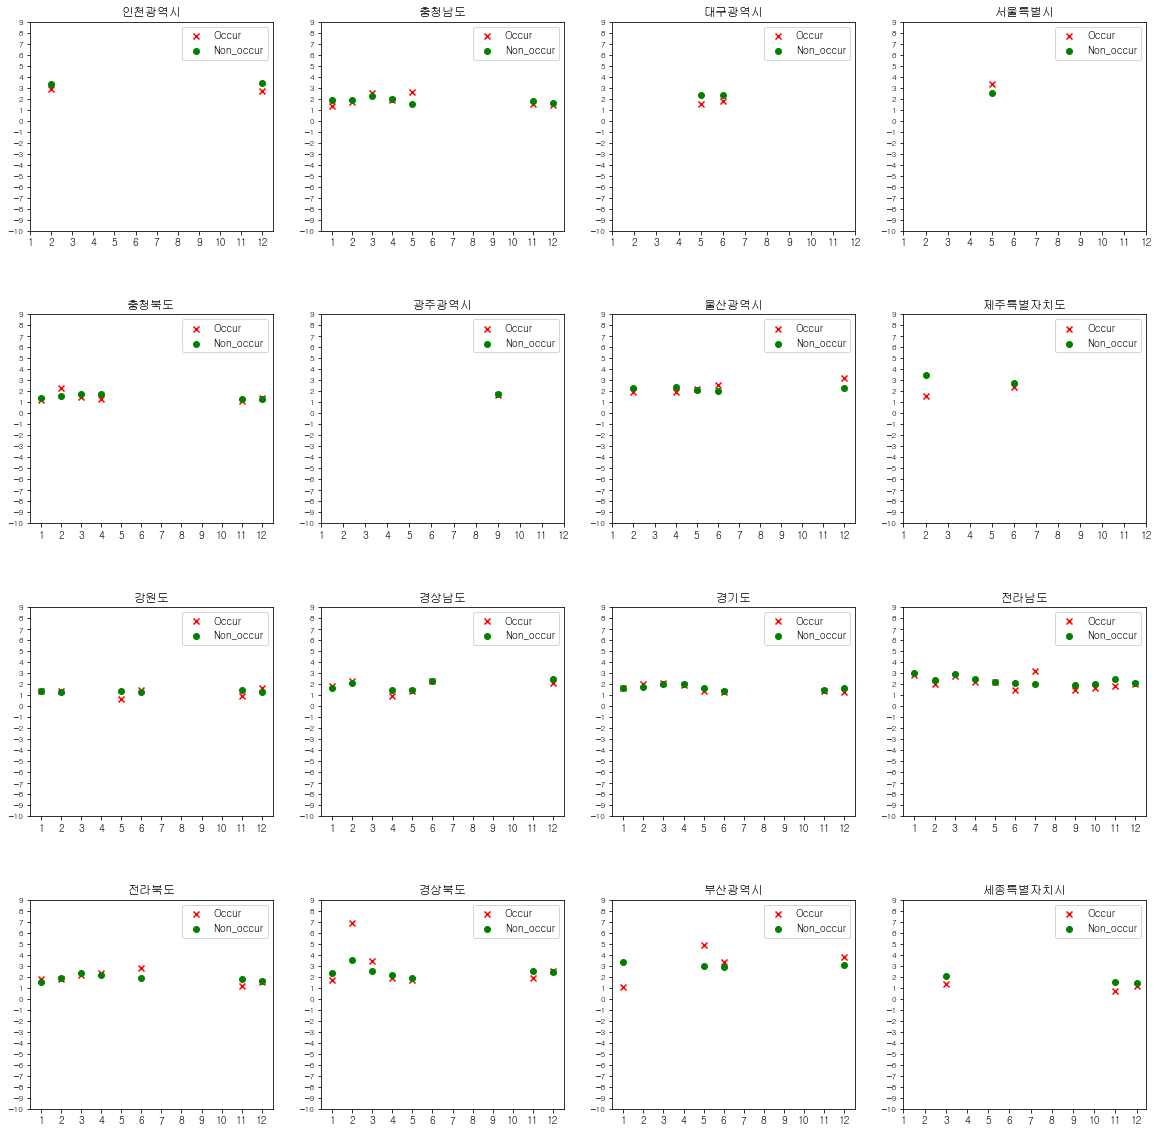

In [329]:
# 풍속차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(occur['시도']))
k=1
for sido in set(occur['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('시도==@sido').reset_index(drop=True)
    temp2=other.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['avg_wind(m/s)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['avg_wind(m/s)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(-10,10), size=8)
    plt.xticks(range(1,13))
    plt.legend()

- 풍속
    - 시도별 특징은 찾기 어려움
    - 계절적 특징도 찾기 어려움
    - 무의미한 data로 판단

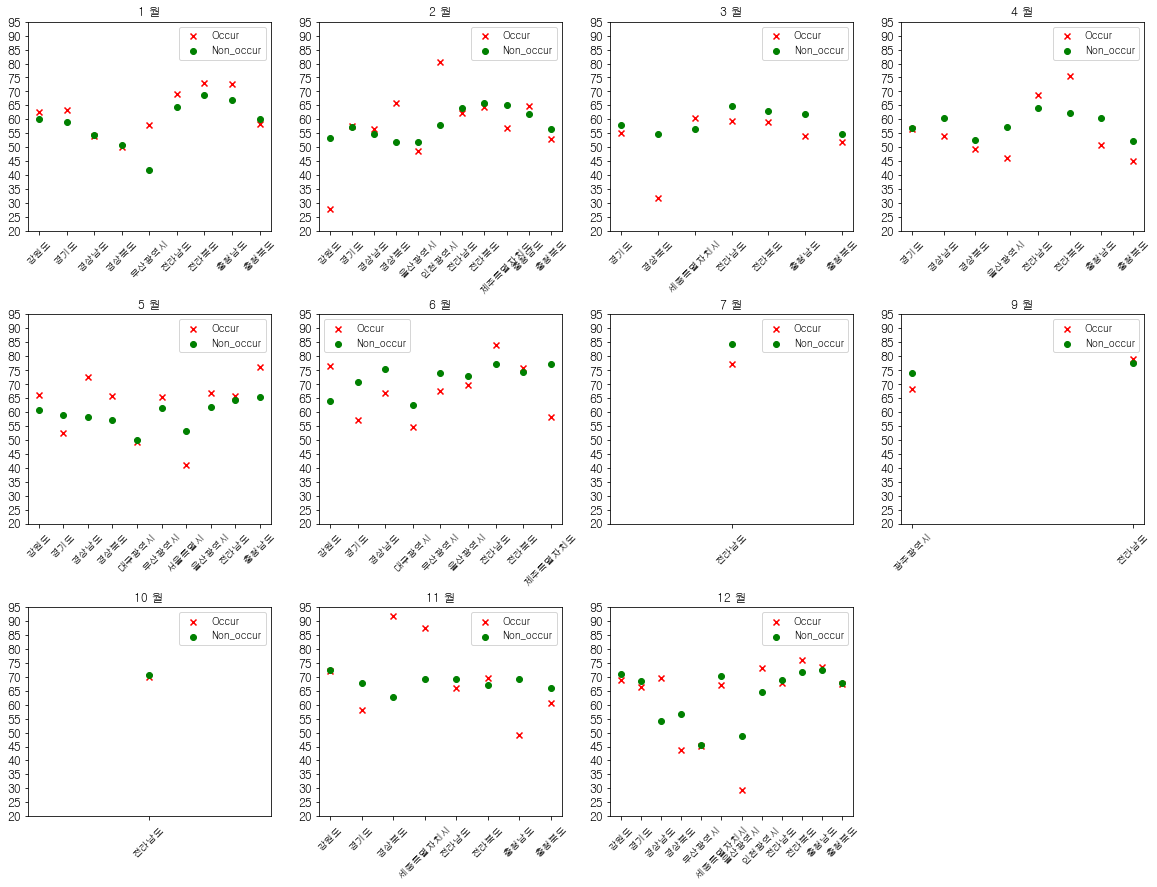

In [338]:
# 상대습도차이 그래프
plt.figure(figsize=(20,20))
cnt=len(set(occur['month']))
k=1
for month in set(occur['month']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('month==@month').reset_index(drop=True)
    temp2=other.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['avg_r_humidity(%)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['avg_r_humidity(%)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(20,100,5), size=12)
    plt.xticks(rotation=45)
    plt.legend()

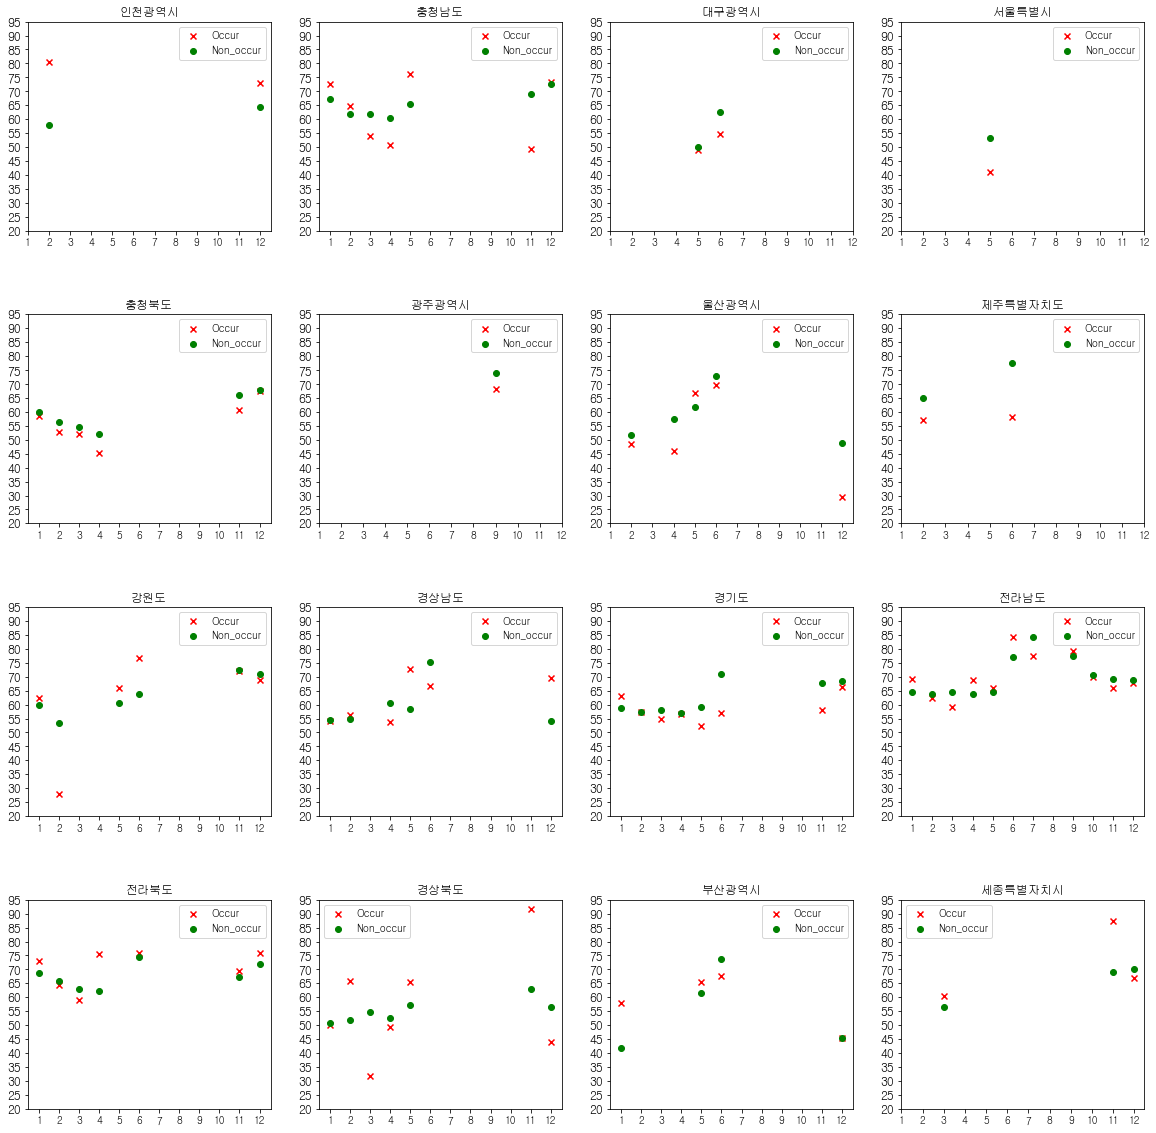

In [339]:
# 상대습도차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(occur['시도']))
k=1
for sido in set(occur['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=occur.query('시도==@sido').reset_index(drop=True)
    temp2=other.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['avg_r_humidity(%)'], marker="x",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['avg_r_humidity(%)'], marker="o",color='g',label="Non_occur")
    plt.yticks(range(20,100,5), size=12)
    plt.xticks(range(1,13))
    plt.legend()

- 상대습도
    - 시도별 특징은 찾기 어려움
    - 계절적 특징도 찾기 어려움
    - 무의미한 data로 판단

In [261]:
# 평균이 아닌 75%, 25% 범위로 보자 (시군에서 시도로 변환시)
sido_df.head()

,year,month,시도,시군구,지역코드,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),cnt
0,2003,12,경기도,이천시,203,0.00,0.0,1.600000,66.100,2
1,2003,12,경상북도,경주시,138,6.65,0.0,2.625000,44.775,4
2,2003,12,울산광역시,울주군,152,0.30,0.0,3.200000,29.400,2
3,2003,12,전라남도,나주시,156,0.75,0.0,1.400000,70.200,2
4,2003,12,충청남도,천안시,232,0.00,0.0,1.633333,76.000,3


In [262]:
other_sido_df.head()

,year,month,시도,시군구,지역코드,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,2005.0,1.0,강원도,인제군,211.0,-5.4,0.3,1.8,60.9
1,2005.0,1.0,강원도,횡성군,114.0,-3.3,0.1,1.3,55.8
2,2005.0,1.0,경기도,광주시,203.0,-3.1,0.1,1.2,62.1
3,2005.0,1.0,경기도,김포시,112.0,-1.1,0.1,3.1,54.1
4,2005.0,1.0,경기도,남양주시,108.0,-2.5,0.1,2.4,52.2


In [268]:
sido_df_75=np.round(sido_df.groupby(['month','시도']).quantile(.75),1)
sido_df_75.reset_index(inplace=True)

In [270]:
sido_df_75.drop(['year','지역코드'], axis=1, inplace=True)

In [272]:
sido_df_75.head()

,month,시도,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),cnt
0,1,강원도,3.2,0.0,1.8,63.7,1.0
1,1,경기도,1.1,0.7,2.0,71.3,3.0
2,1,경상남도,2.9,0.0,2.3,59.8,2.0
3,1,경상북도,0.4,0.2,2.0,56.3,1.0
4,1,부산광역시,6.1,0.0,1.1,58.0,2.0


In [288]:
sido_df_25=np.round(sido_df.groupby(['month','시도']).quantile(.25),1)
sido_df_25.reset_index(inplace=True)

In [289]:
sido_df_25.drop(['year','지역코드'], axis=1, inplace=True)

In [290]:
sido_df_25.head()

,month,시도,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%),cnt
0,1,강원도,1.9,0.0,1.0,61.3,1.0
1,1,경기도,-7.6,0.0,1.0,56.1,1.0
2,1,경상남도,-4.7,0.0,1.0,52.4,1.0
3,1,경상북도,-2.4,0.0,1.2,42.8,1.0
4,1,부산광역시,6.1,0.0,1.1,58.0,2.0


In [278]:
other_sido_df['month']=other_sido_df['month'].astype('int')

In [285]:
other_df_25=np.round(other_sido_df.groupby(['month','시도']).quantile(.25),1)
other_df_25.reset_index(inplace=True)

In [286]:
other_df_25.drop(['year','지역코드'], axis=1, inplace=True)

In [287]:
other_df_25.head()

,month,시도,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,1,강원도,-5.5,0.1,1.2,57.1
1,1,경기도,-4.4,0.1,1.3,53.6
2,1,경상남도,-0.6,0.3,1.2,51.6
3,1,경상북도,-2.1,0.2,2.0,45.5
4,1,부산광역시,2.5,0.5,3.1,41.6


In [291]:
other_df_75=np.round(other_sido_df.groupby(['month','시도']).quantile(.75),1)
other_df_75.reset_index(inplace=True)

In [292]:
other_df_75.drop(['year','지역코드'], axis=1, inplace=True)

In [293]:
other_df_75.head()

,month,시도,avg_temp(C),daily_rain(mm),avg_wind(m/s),avg_r_humidity(%)
0,1,강원도,-3.8,0.3,1.5,62.7
1,1,경기도,-2.4,0.3,1.7,62.8
2,1,경상남도,0.9,0.4,1.8,57.0
3,1,경상북도,1.0,0.8,2.6,55.4
4,1,부산광역시,3.5,0.6,3.4,42.3


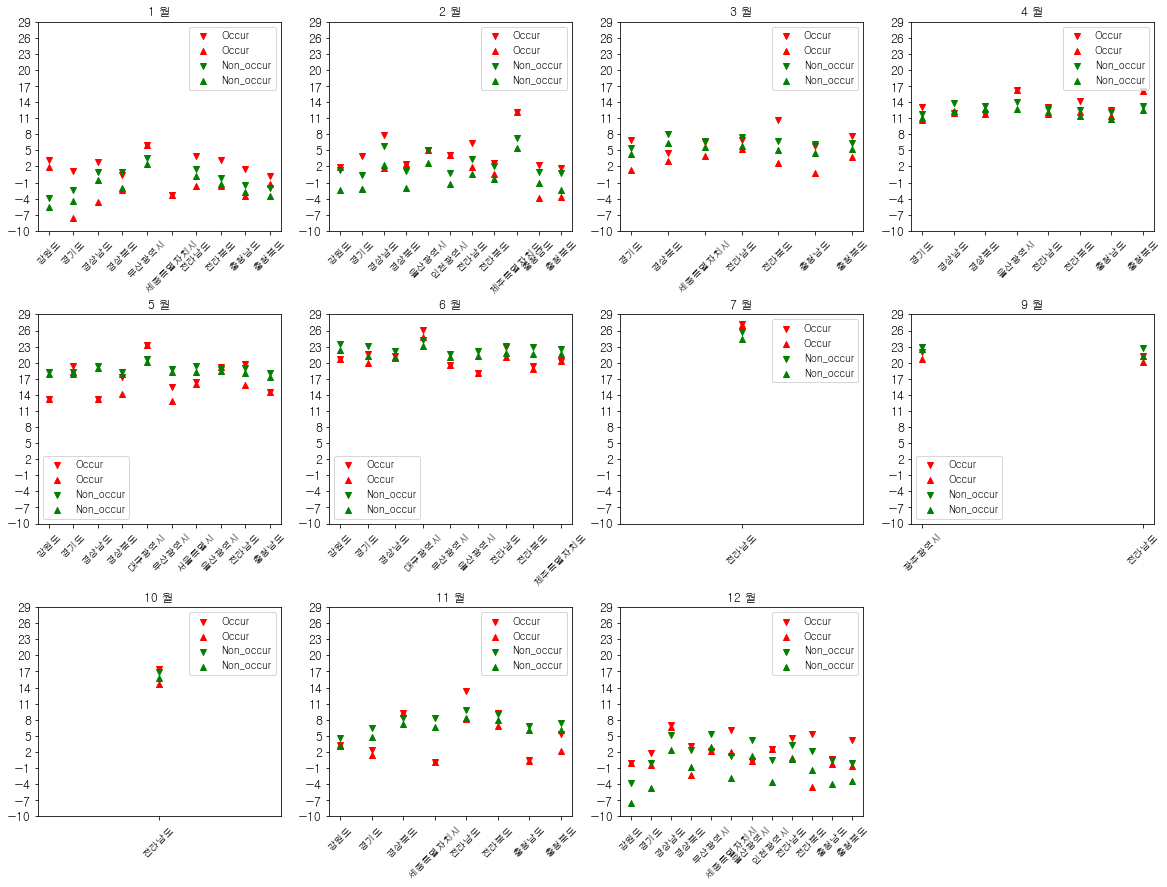

In [342]:
# 온도차이 그래프 (월별) # 위 근거를 토대로 자세하게 살펴보기 (IQR 25,75)
plt.figure(figsize=(20,20))
cnt=len(set(sido_df_75['month']))
k=1
for month in set(sido_df_75['month']): # 1~12월별 8월은 발생 data 없음!
    temp=sido_df_75.query('month==@month').reset_index(drop=True)
    temp2=sido_df_25.query('month==@month').reset_index(drop=True)
    temp3=other_df_75.query('month==@month').reset_index(drop=True)
    temp4=other_df_25.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['avg_temp(C)'], marker="v",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['avg_temp(C)'], marker="^",color='r',label="Occur")
    plt.scatter(temp3['시도'], temp3['avg_temp(C)'], marker="v",color='g',label="Non_occur")
    plt.scatter(temp4['시도'], temp4['avg_temp(C)'], marker="^",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(rotation=45)
    plt.legend()

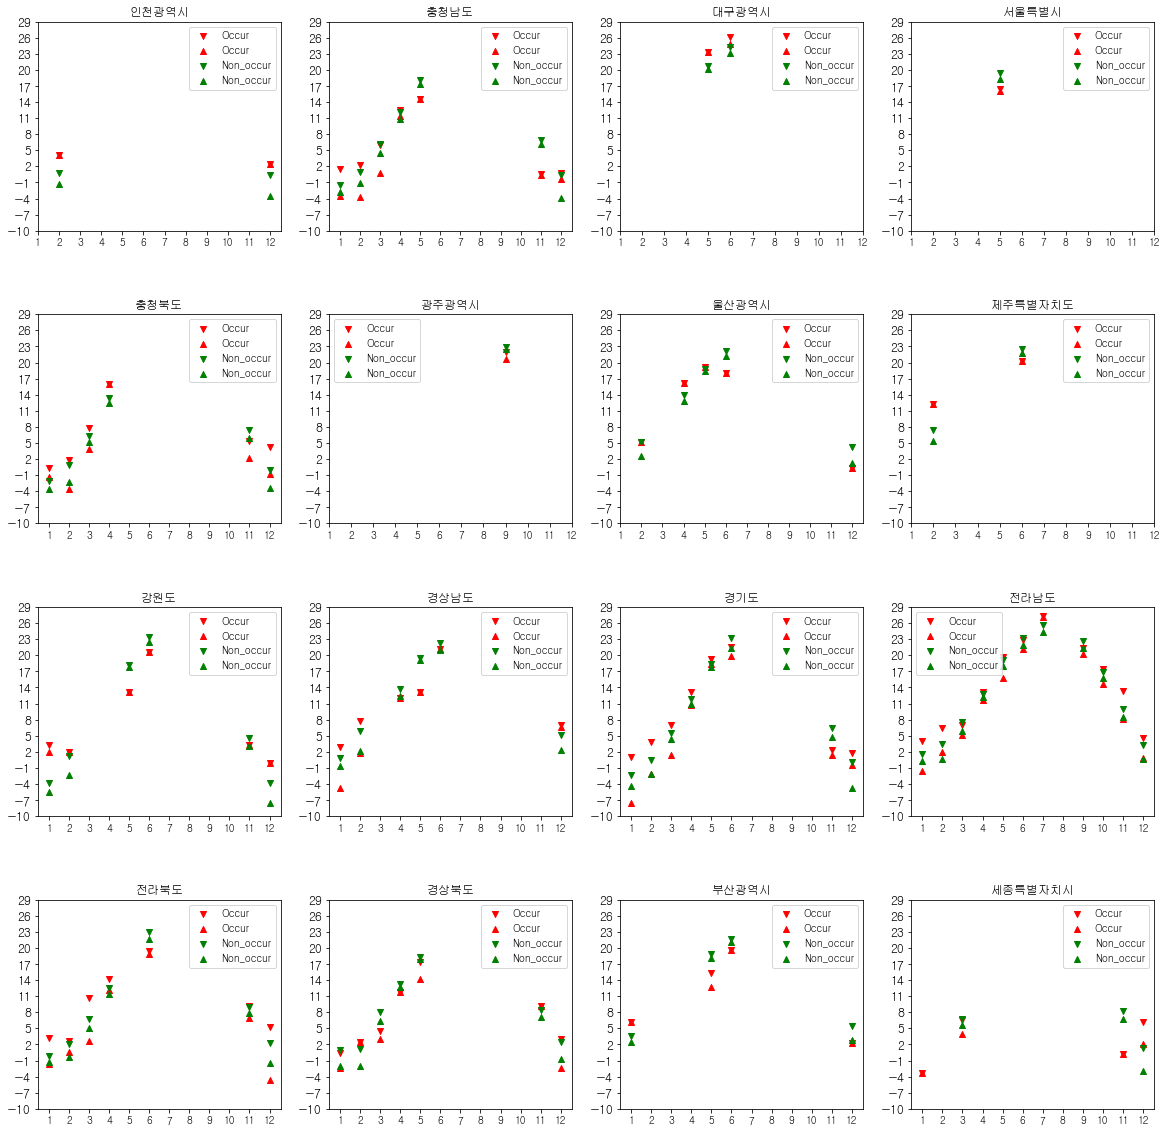

In [343]:
# 온도차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(sido_df_75['시도']))
k=1
for sido in set(sido_df_75['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=sido_df_75.query('시도==@sido').reset_index(drop=True)
    temp2=sido_df_25.query('시도==@sido').reset_index(drop=True)
    temp3=other_df_75.query('시도==@sido').reset_index(drop=True)
    temp4=other_df_25.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['avg_temp(C)'], marker="v",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['avg_temp(C)'], marker="^",color='r',label="Occur")
    plt.scatter(temp3['month'], temp3['avg_temp(C)'], marker="v",color='g',label="Non_occur")
    plt.scatter(temp4['month'], temp4['avg_temp(C)'], marker="^",color='g',label="Non_occur")
    plt.yticks(range(-10,30,3), size=12)
    plt.xticks(range(1,13))
    plt.legend()

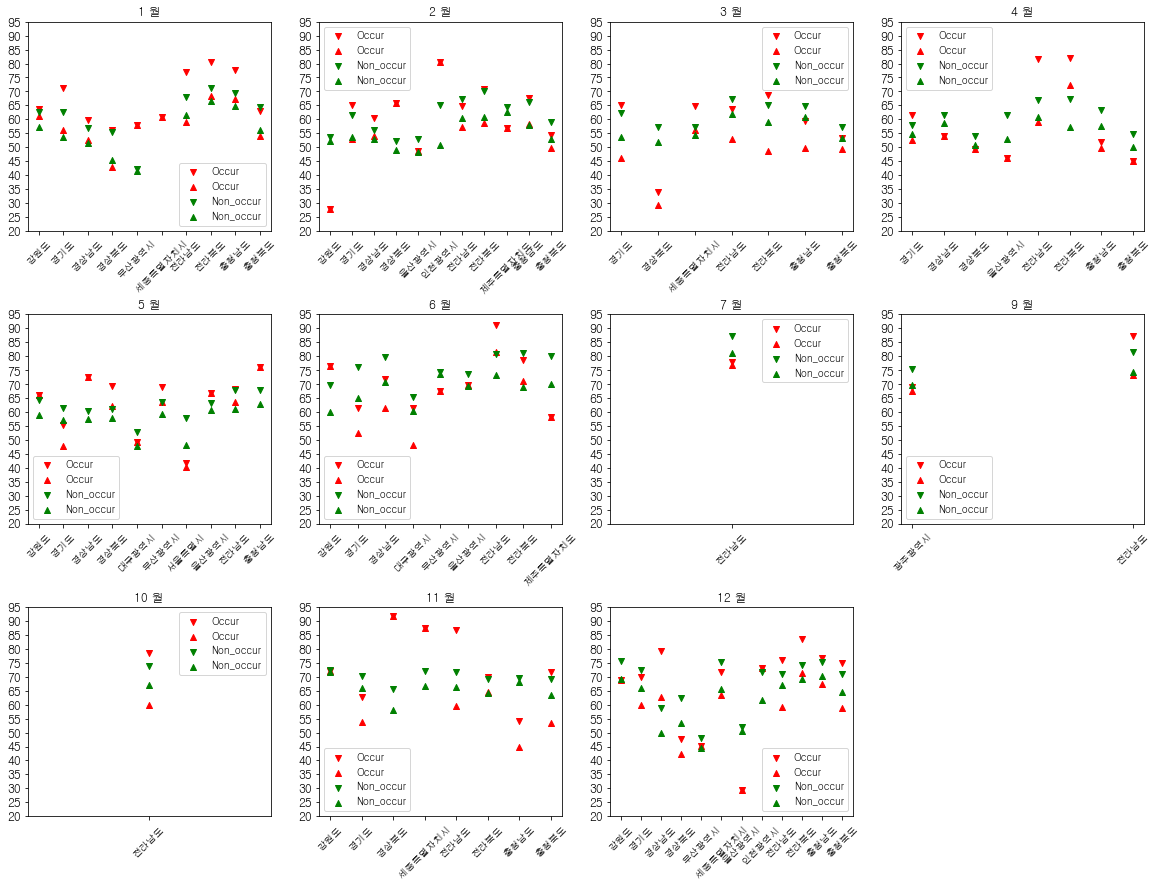

In [340]:
# 습도차이 그래프(월별)
plt.figure(figsize=(20,20))
cnt=len(set(sido_df_75['month']))
k=1
for month in set(sido_df_75['month']): # 1~12월별 8월은 발생 data 없음!
    temp=sido_df_75.query('month==@month').reset_index(drop=True)
    temp2=sido_df_25.query('month==@month').reset_index(drop=True)
    temp3=other_df_75.query('month==@month').reset_index(drop=True)
    temp4=other_df_25.query('month==@month').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(month)+" 월")
    plt.scatter(temp['시도'], temp['avg_r_humidity(%)'], marker="v",color='r',label="Occur")
    plt.scatter(temp2['시도'], temp2['avg_r_humidity(%)'], marker="^",color='r',label="Occur")
    plt.scatter(temp3['시도'], temp3['avg_r_humidity(%)'], marker="v",color='g',label="Non_occur")
    plt.scatter(temp4['시도'], temp4['avg_r_humidity(%)'], marker="^",color='g',label="Non_occur")
    plt.yticks(range(20,100,5), size=12)
    plt.xticks(rotation=45)
    plt.legend()

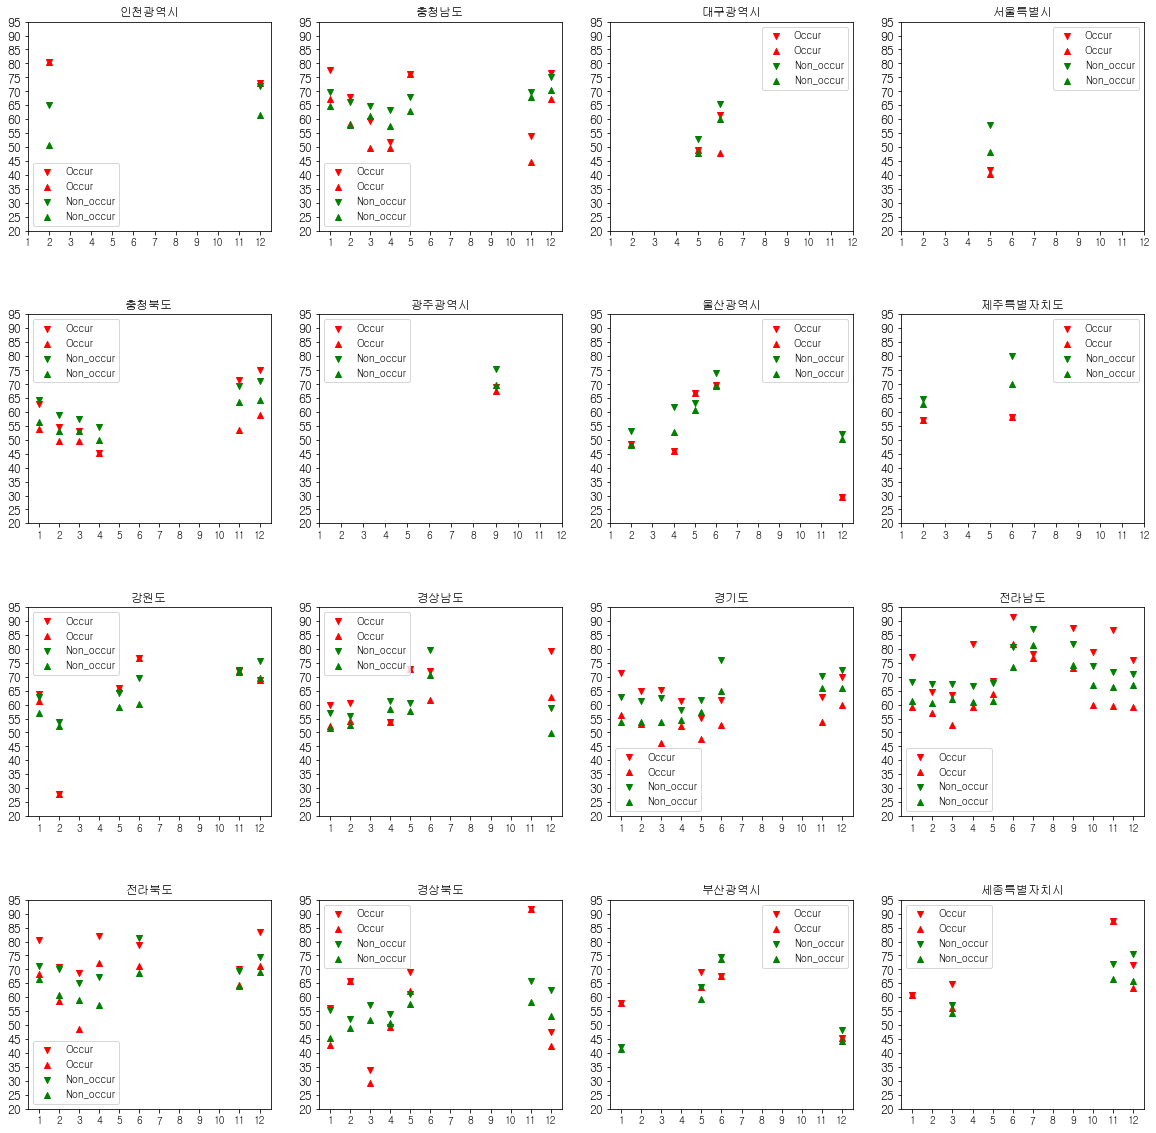

In [341]:
# 습도차이 그래프 (시도별)
plt.figure(figsize=(20,20))
cnt=len(set(sido_df_75['시도']))
k=1
for sido in set(sido_df_75['시도']): # 1~12월별 8월은 발생 data 없음!
    temp=sido_df_75.query('시도==@sido').reset_index(drop=True)
    temp2=sido_df_25.query('시도==@sido').reset_index(drop=True)
    temp3=other_df_75.query('시도==@sido').reset_index(drop=True)
    temp4=other_df_25.query('시도==@sido').reset_index(drop=True)
    plt.subplot(int(np.ceil(np.sqrt(cnt))),int(np.ceil(np.sqrt(cnt))),k)
    plt.subplots_adjust(hspace=0.4)
    k+=1
    plt.title(str(sido))
    plt.scatter(temp['month'], temp['avg_r_humidity(%)'], marker="v",color='r',label="Occur")
    plt.scatter(temp2['month'], temp2['avg_r_humidity(%)'], marker="^",color='r',label="Occur")
    plt.scatter(temp3['month'], temp3['avg_r_humidity(%)'], marker="v",color='g',label="Non_occur")
    plt.scatter(temp4['month'], temp4['avg_r_humidity(%)'], marker="^",color='g',label="Non_occur")
    plt.yticks(range(20,100,5), size=12)
    plt.xticks(range(1,13))
    plt.legend()

#### RISK TABLE SET 제작
    1. 위 그래프에서 occur과 non_occur과의 관계성이 나와있는 것만으로 table을 제작함
    2. 여름 5-9월 까지는 상대적으로 낮은 온도에서 발생하는 경향이 있음. (7~9월은 data 부족으로 판단)
       반면에 겨울에는 겨울 평상시 온도보다 약간 더 높은 온도에서 발생하는 경향이 있음 (12~2월) 
    3. 여름 5-9월 까지는 상대적으로 낮은 강수량일 경우 발생하는 경향이 있음. (7~9월은 data 부족으로 판단)

In [241]:
sido=list(set(occur['시도']))+['대전광역시']
cols_weather=['avg_temp(C)','daily_rain(mm)','avg_wind(m/s)','avg_r_humidity(%)']
# 강수량은 의미가 적으므로 가중치를 덜 줌
cols_weight={'index_avg_temp(C)':3.0,'index_daily_rain(mm)':1.0,'index_avg_wind(m/s)':3.0,'index_avg_r_humidity(%)':3.0}

In [242]:
# 10등분 table 제작
table=pd.DataFrame(columns=['month','시도']+cols_weather+list(cols_weight.keys())+['Risk'])
for month in range(1,13): #월별
    for si_do in sido: # 10개구간 빈 dataset 만들기
        temp=pd.DataFrame(index=range(10),columns=['month','시도'])
        temp['month']=month
        temp['시도']=si_do
        table=table.append(temp, ignore_index=True)

In [243]:
# 등분 기준 만들기
for n, group in tqdm(table.groupby(['month','시도'])):
    mon=n[0]
    sido=n[1]
    if sido=='대전광역시':  # 아예 없는 data
        sido='충청남도'
    occ=occur.query('month==@mon and 시도==@sido').reset_index(drop=True)
    oth=other.query('month==@mon and 시도==@sido').reset_index(drop=True)
    for col in cols_weather:
        if len(occ)!=0: # data가 있는 경우만..
            max_val=occ.loc[0,col]  # occur에 가까울수록 최고 점수
            min_val=oth.loc[0,col] # other에 가까울수록 최저 점수
            if max_val!=min_val:  # 두 data가 서로 같은 값이 아닌 경우
                table.loc[group.index[0],'index_'+col]= 10 # 최고 점수
                table.loc[group.index[0],col]=max_val
                table.loc[group.index[-1],'index_'+col]=0  # 최저 점수
                table.loc[group.index[-1],col]=min_val
                for index in group.index[1:-1]:
                    table.loc[index,'index_'+col]=table.loc[index-1,'index_'+col]-1
                    temp=np.round(table.loc[index-1,col]-((max_val-min_val)/len(group.index)), 3)  # 소수 셋째자리까지 등분
                    table.loc[index,col]=temp
            else: # 두 데이터 값이 서로 같은 경우는 가중치 0점 부여
                for index in group.index:
                    table.loc[index,'index_'+col]=0
                    table.loc[index,col]=max_val
    
        else: # data가 없는 경우.. 발생하지 않는다라고 가정!, 가중치 0점 부여
            for index in group.index:
                table.loc[index,'index_'+col]=0
                table.loc[index,col]=0  # 실제 값도 0으로 일단 제작

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:04<00:00, 50.83it/s]


In [244]:
# Risk 값 부여
for i in range(len(table)):
    cnt=0
    for col in cols_weight.keys():
        cnt+=table.loc[i,col]*cols_weight[col]
    table.loc[i,'Risk']=cnt

In [245]:
table.to_csv("Weather_Risk_table.csv", encoding='utf-8-sig', index=False)